# Pipeline processing using arlexecute workflows.

This notebook demonstrates the continuum imaging and ICAL pipelines. These are based on ARL functions wrapped up as SDP workflows using the arlexecute class.

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path

results_dir = arl_path('test_results')

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from data_models.polarisation import PolarisationFrame

from wrappers.serial.calibration.calibration import solve_gaintable
from wrappers.serial.calibration.operations import apply_gaintable
from wrappers.serial.calibration.calibration_control import create_calibration_controls
from wrappers.serial.visibility.base import create_blockvisibility
from wrappers.serial.skycomponent.operations import create_skycomponent
from wrappers.serial.image.deconvolution import deconvolve_cube
from wrappers.serial.image.operations import show_image, export_image_to_fits, qa_image
from wrappers.serial.visibility.iterators import vis_timeslice_iter
from wrappers.serial.simulation.testing_support import create_named_configuration, create_low_test_image_from_gleam
from wrappers.serial.imaging.base import predict_2d, create_image_from_visibility, advise_wide_field
from wrappers.serial.visibility.coalesce import convert_blockvisibility_to_visibility

from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow, \
    predict_list_arlexecute_workflow, deconvolve_list_arlexecute_workflow
from workflows.arlexecute.simulation.simulation_arlexecute import simulate_list_arlexecute_workflow, \
    corrupt_list_arlexecute_workflow
from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow

from wrappers.arlexecute.execution_support.arlexecute import arlexecute

import pprint

pp = pprint.PrettyPrinter()

import logging

def init_logging():
    log = logging.getLogger()
    logging.basicConfig(filename='%s/imaging-pipeline.log' % results_dir,
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.INFO)
log = logging.getLogger()
logging.info("Starting imaging-pipeline")


We will use dask

In [2]:
arlexecute.set_client(use_dask=True)
arlexecute.run(init_logging)

{'tcp://127.0.0.1:57073': None,
 'tcp://127.0.0.1:57074': None,
 'tcp://127.0.0.1:57075': None,
 'tcp://127.0.0.1:57077': None,
 'tcp://127.0.0.1:57079': None,
 'tcp://127.0.0.1:57081': None,
 'tcp://127.0.0.1:57084': None,
 'tcp://127.0.0.1:57089': None}

In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [4]:
nfreqwin=7
ntimes=5
rmax=300.0
frequency=numpy.linspace(1e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

bvis_list=simulate_list_arlexecute_workflow('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax, format='blockvis')
vis_list = [arlexecute.execute(convert_blockvisibility_to_visibility)(bv) for bv in bvis_list]

print('%d elements in vis_list' % len(vis_list))
log.info('About to make visibility')
vis_list = arlexecute.compute(vis_list, sync=True)

7 elements in vis_list


In [5]:
wprojection_planes=1
advice_low=advise_wide_field(vis_list[0], guard_band_image=8.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

advice_high=advise_wide_field(vis_list[-1], guard_band_image=8.0, delA=0.02,
                              wprojection_planes=wprojection_planes)

vis_slices = advice_low['vis_slices']
npixel=advice_high['npixels2']
cellsize=min(advice_low['cellsize'], advice_high['cellsize'])

Now make a graph to fill with a model drawn from GLEAM 

In [6]:
gleam_model = [arlexecute.execute(create_low_test_image_from_gleam)(npixel=npixel,
                                                               frequency=[frequency[f]],
                                                               channel_bandwidth=[channel_bandwidth[f]],
                                                               cellsize=cellsize,
                                                               phasecentre=phasecentre,
                                                               polarisation_frame=PolarisationFrame("stokesI"),
                                                               flux_limit=1.0,
                                                               applybeam=True)
                     for f, freq in enumerate(frequency)]
log.info('About to make GLEAM model')
gleam_model = arlexecute.compute(gleam_model, sync=True)
future_gleam_model = arlexecute.scatter(gleam_model)

In [7]:
log.info('About to run predict to get predicted visibility')
future_vis_graph = arlexecute.scatter(vis_list)
predicted_vislist = predict_list_arlexecute_workflow(future_vis_graph, gleam_model,  
                                                context='wstack', vis_slices=vis_slices)
predicted_vislist = arlexecute.compute(predicted_vislist, sync=True)
corrupted_vislist = corrupt_list_arlexecute_workflow(predicted_vislist, phase_error=1.0)
log.info('About to run corrupt to get corrupted visibility')
corrupted_vislist =  arlexecute.compute(corrupted_vislist, sync=True)
future_predicted_vislist=arlexecute.scatter(predicted_vislist)

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:901: UserWarning: Large object of size 2.10 MB detected in task graph: 
  ('getitem-6f930a7e4a0797056ee76974008a8945', <data ... -b9fe8d2d1d4f')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


Get the LSM. This is currently blank.

In [8]:
model_list = [arlexecute.execute(create_image_from_visibility)(vis_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

In [9]:
dirty_list = invert_list_arlexecute_workflow(future_predicted_vislist, model_list, 
                                  context='wstack',
                                  vis_slices=vis_slices, dopsf=False)
psf_list = invert_list_arlexecute_workflow(future_predicted_vislist, model_list, 
                                context='wstack',
                                vis_slices=vis_slices, dopsf=True)

Create and execute graphs to make the dirty image and PSF

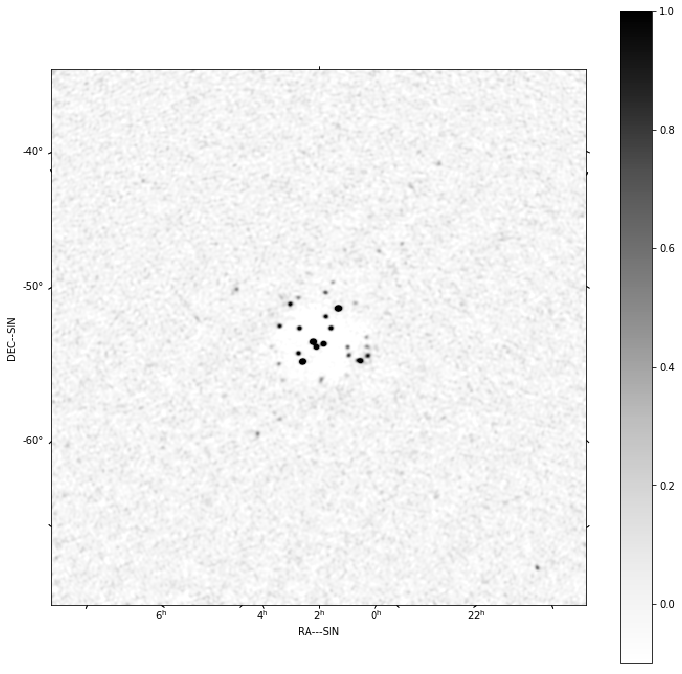

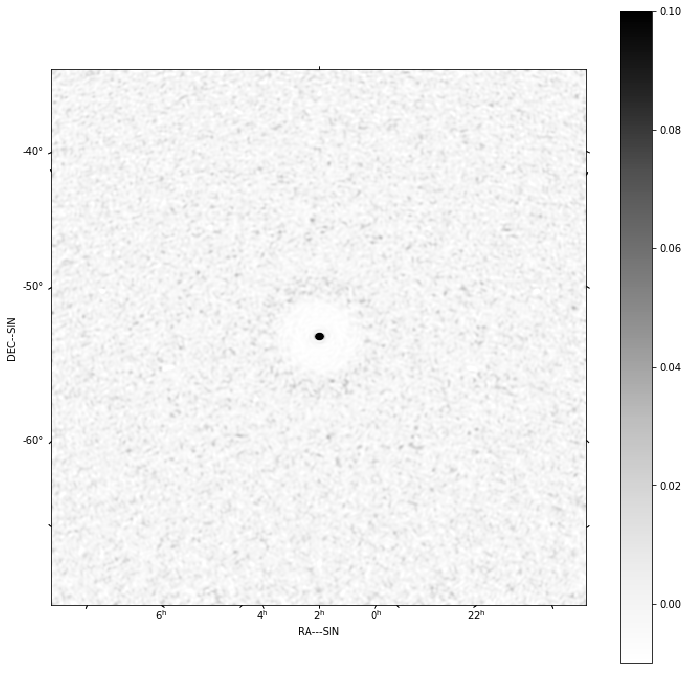

In [10]:
log.info('About to run invert to get dirty image')

dirty_list =  arlexecute.compute(dirty_list, sync=True)
dirty = dirty_list[0][0]
show_image(dirty, cm='Greys', vmax=1.0, vmin=-0.1)
plt.show()

log.info('About to run invert to get PSF')


psf_list =  arlexecute.compute(psf_list, sync=True)
psf = psf_list[0][0]
show_image(psf, cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()

Now deconvolve using msclean

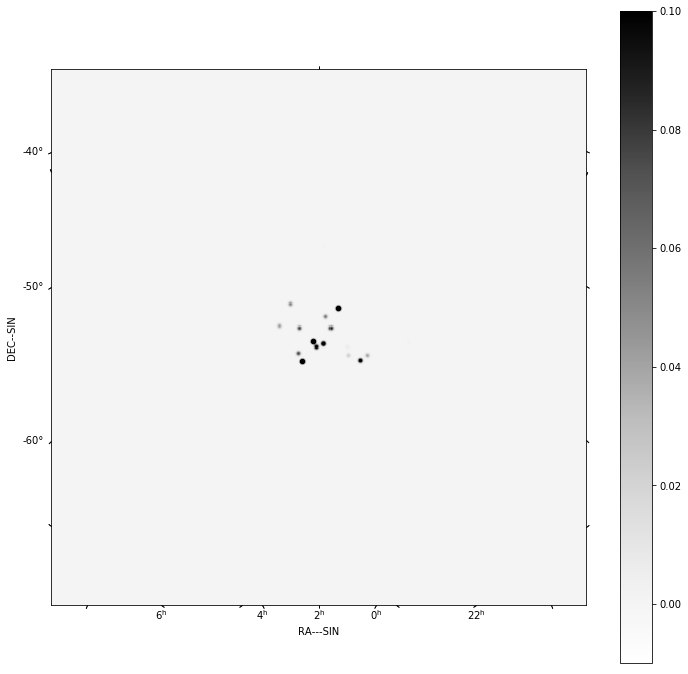

In [11]:
log.info('About to run deconvolve')

deconvolve_list = \
    deconvolve_list_arlexecute_workflow(dirty_list, psf_list, model_imagelist=model_list, 
                            deconvolve_facets=8, deconvolve_overlap=16, deconvolve_taper='tukey',
                            scales=[0, 3, 10],
                            algorithm='msclean', niter=1000, 
                            fractional_threshold=0.1,
                            threshold=0.1, gain=0.1, psf_support=64)
    
deconvolved = arlexecute.compute(deconvolve_list, sync=True)
show_image(deconvolved[0], cm='Greys', vmax=0.1, vmin=-0.01)
plt.show()

In [12]:
continuum_imaging_list = \
    continuum_imaging_list_arlexecute_workflow(future_predicted_vislist, 
                                            model_imagelist=model_list, 
                                            context='wstack', vis_slices=vis_slices, 
                                            scales=[0, 3, 10], algorithm='mmclean', 
                                            nmoment=3, niter=1000, 
                                            fractional_threshold=0.1,
                                            threshold=0.1, nmajor=5, gain=0.25,
                                            deconvolve_facets = 8, deconvolve_overlap=16, 
                                            deconvolve_taper='tukey', psf_support=64)


Quality assessment:
	Origin: qa_image
	Context: Clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '4.842959906577232'
		min: '-0.027235420546758406'
		rms: '0.018787977038019456'
		sum: '45.67280258115075'
		medianabs: '0.0'
		median: '0.0'



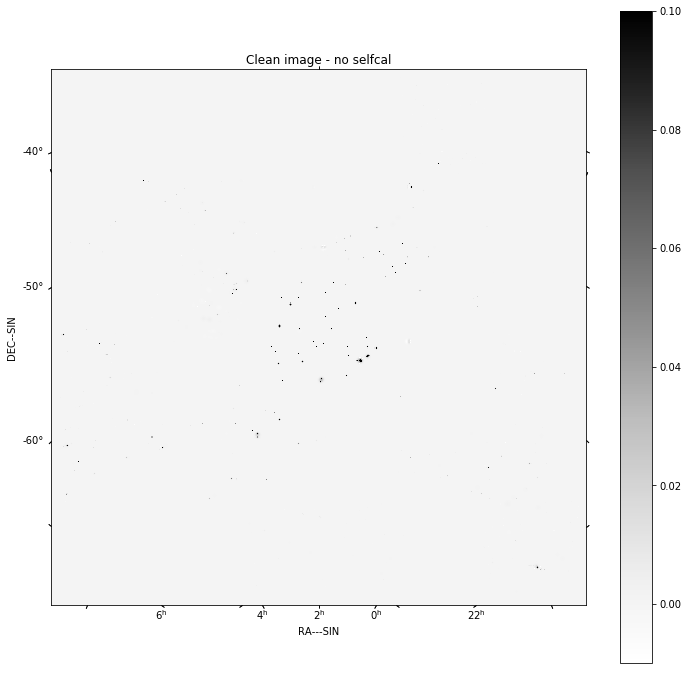

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '4.925369166163191'
		min: '-0.018669648408504776'
		rms: '0.06505129575342065'
		sum: '964.9945646355784'
		medianabs: '0.002774263073591076'
		median: '-0.0002634324763573971'



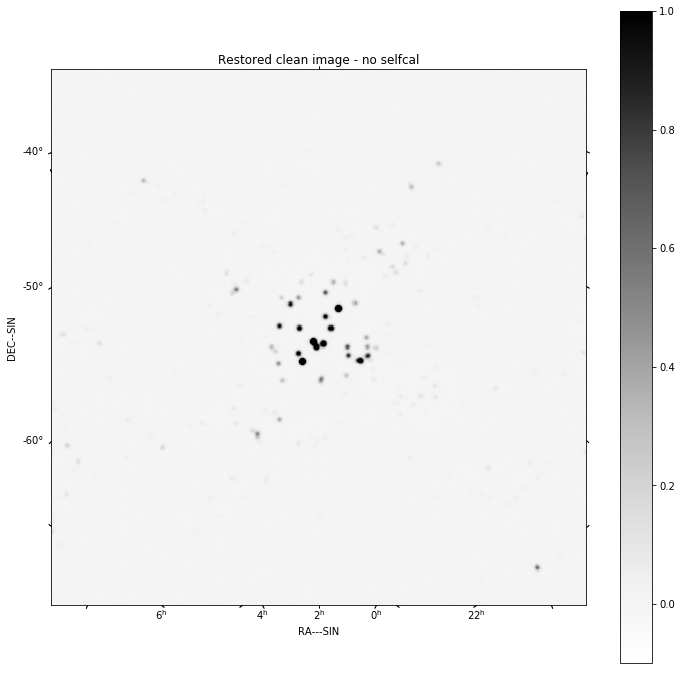

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '0.14199483358773465'
		min: '-0.07213947554890467'
		rms: '0.0057468489024988705'
		sum: '8.926777691337618'
		medianabs: '0.002738244963509266'
		median: '-0.0003941375238860733'



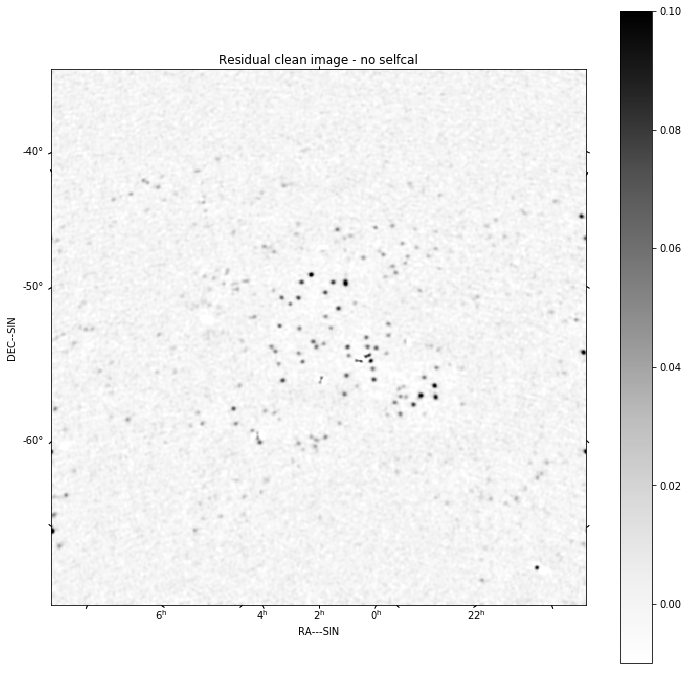

In [13]:
log.info('About to run continuum imaging')

continuum_imaging_list=arlexecute.compute(continuum_imaging_list, sync=True)
deconvolved = continuum_imaging_list[0][0]
residual = continuum_imaging_list[1][0]
restored = continuum_imaging_list[2][0]

f=show_image(deconvolved, title='Clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal', 
             cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))

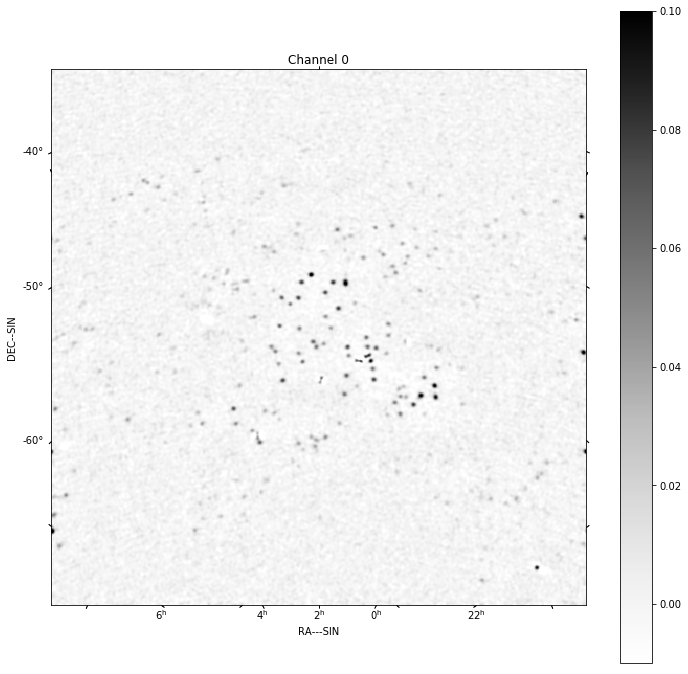

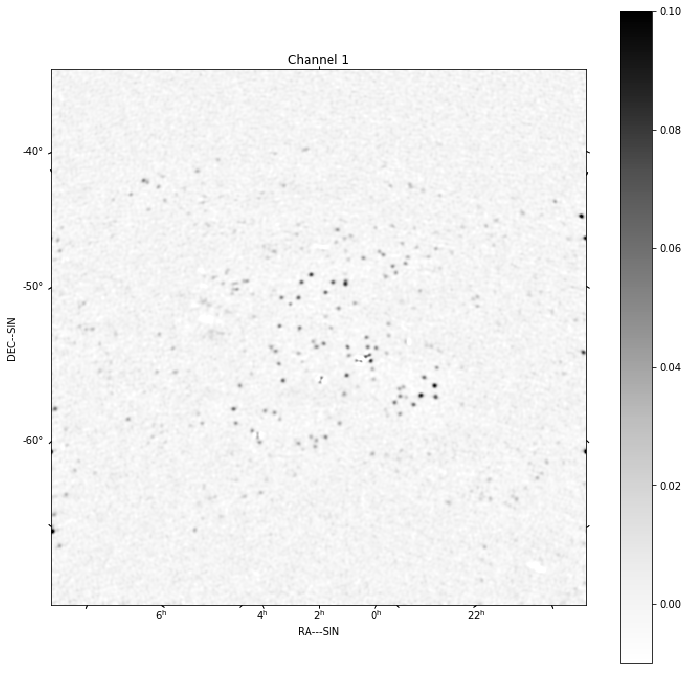

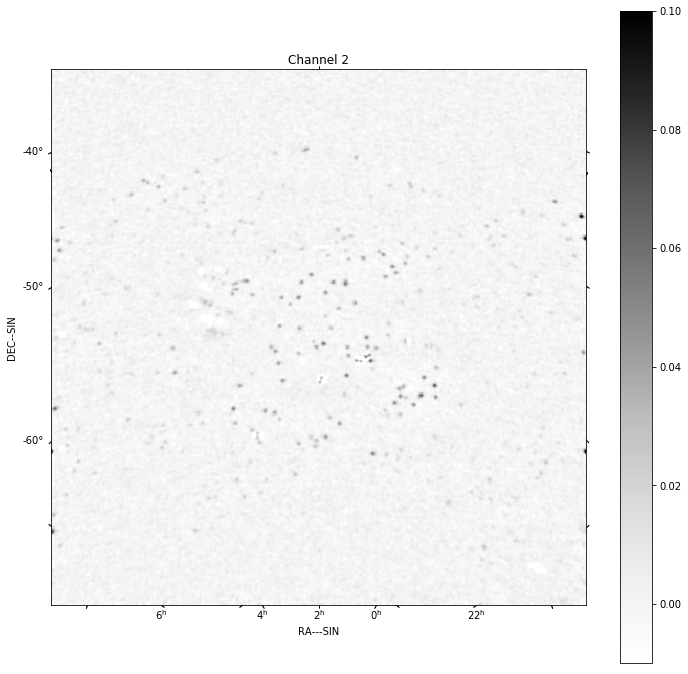

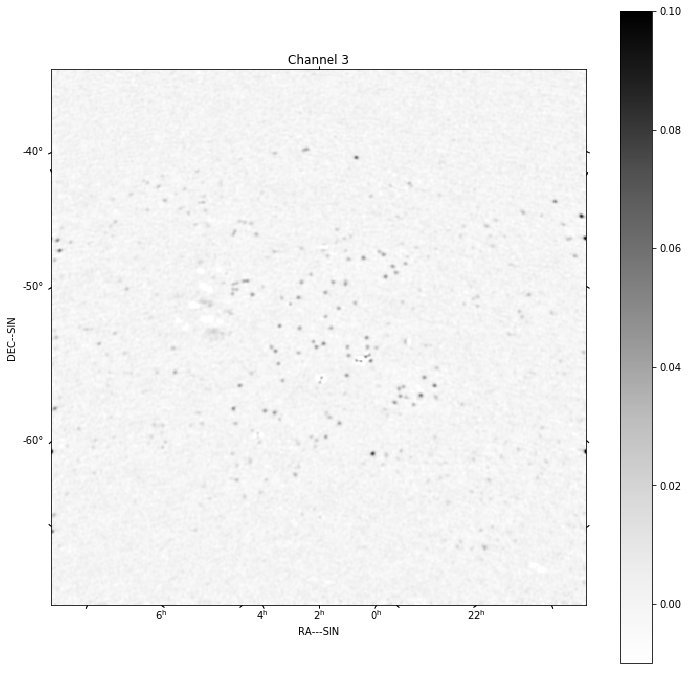

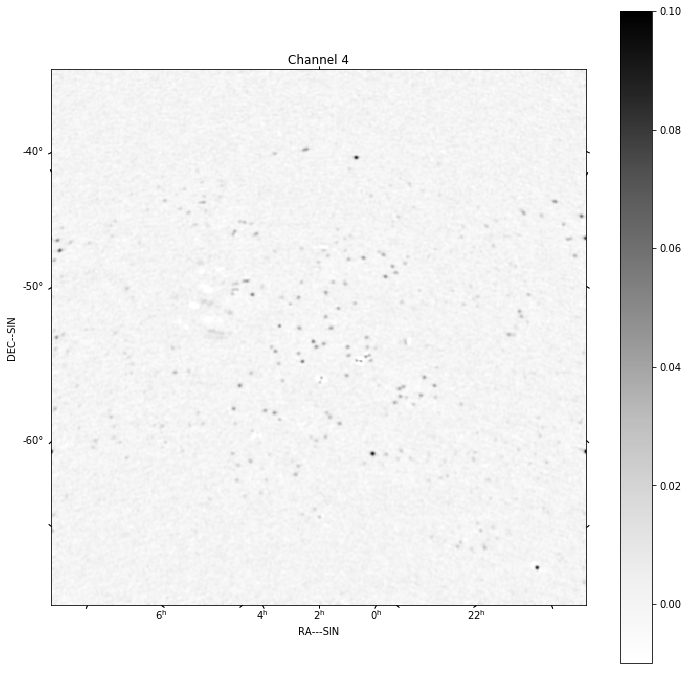

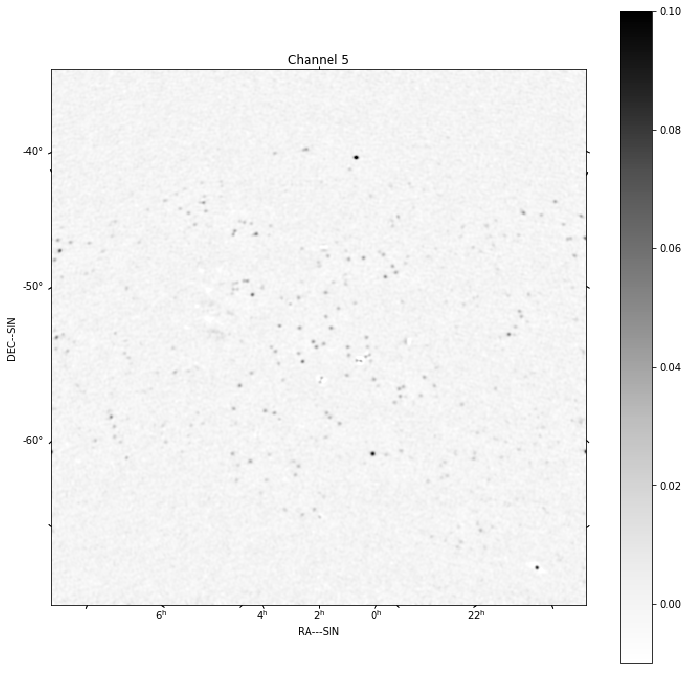

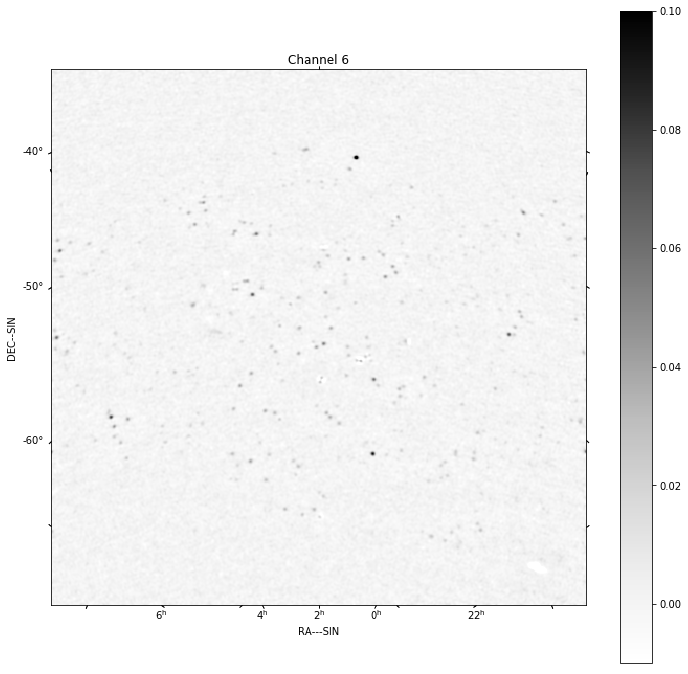

In [14]:
for chan in range(nfreqwin):
    residual = continuum_imaging_list[1][chan]
    show_image(residual[0], title='Channel %d' % chan, cm='Greys', 
               vmax=0.1, vmin=-0.01)
    plt.show()